In [1]:
#Loading the dataset

from datasets import load_dataset

dataset = load_dataset(r"C:\Users\Navdeep\Downloads\my_custom_dataset.py", name='my_custom_dataset')

In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

model_name = r"C:\Part_dimensions_project\seg_former_model_weights\checkpoint-163"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

C:\Users\Navdeep\anaconda3\envs\part_dim\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [3]:
from PIL import Image
import numpy as np

image_path = r"C:\Part_dimensions_project\dataset\train\images\image_rotated_13.jpg"

image = Image.open(image_path)

image_np = np.array(image)
if len(image_np.shape) == 2:  # Check if the image is grayscale
    image_np = np.stack([image_np] * 3, axis=-1)  # Repeat the grayscale channel three times
image =  Image.fromarray(image_np)

In [4]:
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

In [5]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [6]:
predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

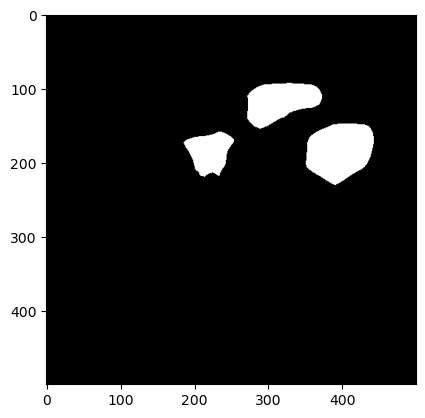

In [7]:
import matplotlib.pyplot as plt

plt.imshow(predicted_segmentation_map , cmap = 'gray')

In [1]:
##training on a small subset of the ADE20k dataset

import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(r"C:\Part_dimensions_project\Segmentation_dataset")

download_data()

In [15]:
#some experimentation

import cv2
import matplotlib.pyplot as plt
import numpy as np
image = Image.open(r"C:\Part_dimensions_project\Segmentation_dataset\ADE20k_toy_dataset\images\training\ADE_train_00000001.jpg")

print(image.mode)

RGB


In [1]:
#code for training on the parts dataset.

from torch.utils.data import Dataset
import os
from PIL import Image
import cv2
import numpy as np
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path ,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "annotations")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        segmentation_map_np = np.array(segmentation_map)
        _, binary_segmentation_map = cv2.threshold(segmentation_map_np, 100, 255, cv2.THRESH_BINARY)
        rescaled_binary_map = binary_segmentation_map / 255

        m_segmentation_map = Image.fromarray(rescaled_binary_map)

        image_np = np.array(image)
        if len(image_np.shape) == 2:  # Check if the image is grayscale
            image_np = np.stack([image_np] * 3, axis=-1)  # Repeat the grayscale channel three times
        m_image = Image.fromarray(image_np)
        
        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(m_image, m_segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [2]:
from transformers import SegformerImageProcessor

root_dir = r"C:\Part_dimensions_project\dataset"
image_processor = SegformerImageProcessor(reduce_labels=False)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [3]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 180
Number of validation examples: 20


In [4]:

encoded_inputs = train_dataset[0]
print(encoded_inputs["pixel_values"].shape)
print(encoded_inputs["labels"].shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [6]:
id2label = {
    0: 'parallel_thickness',
}

label2id = {
    'parallel_thickness': 0,
}

num_labels = len(id2label)

In [7]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=1,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#earlier training loop


import torch
from torch import nn
from sklearn.metrics import accuracy_score
#from torchmetrics.classification import BinaryJaccardIndex
from tqdm.notebook import tqdm
import evaluate

metric = evaluate.load("mean_iou")



# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

save_directory = r"C:\Part_dimensions_project\seg_former_model_weights"
model.train()
for epoch in range(200):  # loop over the dataset multiple times
   model.save_pretrained(save_directory)
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          probabilities = torch.sigmoid(upsampled_logits)
    
          # Threshold to get binary predictions
          predicted = (probabilities > 0.5).int()
          predicted = predicted.squeeze(1)  
          # note that the metric expects predictions + labels as numpy arrays
          #metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
        
        # let's print loss and metrics every 100 batches
        if idx % 10 == 0:
            metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )
                     

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])


NameError: name 'BinaryJaccardIndex' is not defined

In [8]:
#modified and newer training loop

import torch
from torch.utils.data import DataLoader
from transformers import SegformerForSemanticSegmentation
from tqdm.notebook import tqdm
#import evaluate
from torchmetrics.classification import BinaryJaccardIndex

save_directory = r"C:\Part_dimensions_project\seg_former_model_weights"
best_model_path = r"C:\Part_dimensions_project\seg_former_model_weights\best_weights"

#metric = evaluate.load("mean_iou")
metric = BinaryJaccardIndex(ignore_index = 0)


# Define the model and optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.stop_training = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.patience_counter = 0
            model.save_pretrained(best_model_path)
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                self.stop_training = True



# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

for epoch in range(200):  # loop over the dataset multiple times
    model.train()
    #model.save_pretrained(save_directory)
    print("Epoch:", epoch)
    
    # Training phase
    for idx, batch in enumerate(tqdm(train_dataloader)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()


        with torch.no_grad():
          upsampled_logits = torch.nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          probabilities = torch.sigmoid(upsampled_logits)
    
          # Threshold to get binary predictions
          predicted = (probabilities > 0.5).int()
          predicted = predicted.squeeze(1) 
        

        if idx % 10 == 0:
            #metrics = metric._compute(
            #      predictions=predicted.cpu(),
            #      references=labels.cpu(),
            #      num_labels=len(id2label),
            #      ignore_index=255,
            #      reduce_labels=False, # we've already reduced the labels ourselves
            #  )
             score = metric(predicted.cpu() , labels.cpu())         

             print("Loss:", loss.item())
             print("iou:", score)
            #print("Mean accuracy:", metrics["mean_accuracy"])
            

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

        val_loss /= len(valid_dataloader)
        print("Validation Loss:", val_loss)

    # Save the last epoch's weights
    model.save_pretrained(save_directory)
    
    # Check for early stopping and save the best model
    early_stopping(val_loss)
    if early_stopping.stop_training:
        print("Early stopping triggered")
        break


cuda
Epoch: 0


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.724496066570282
iou: tensor(0.5621)
Loss: 0.6175366640090942
iou: tensor(0.9472)
Loss: 0.578401505947113
iou: tensor(0.8951)
Loss: 0.5366206169128418
iou: tensor(0.7771)
Loss: 0.5095824003219604
iou: tensor(0.8677)
Loss: 0.4915350079536438
iou: tensor(0.8047)
Loss: 0.4553448557853699
iou: tensor(0.8657)
Loss: 0.4389503598213196
iou: tensor(0.7502)
Loss: 0.435607373714447
iou: tensor(0.5877)
Validation Loss: 0.3904752790927887
Epoch: 1


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.39484846591949463
iou: tensor(0.8103)
Loss: 0.3932567536830902
iou: tensor(0.5487)
Loss: 0.4086824655532837
iou: tensor(0.5990)
Loss: 0.37452229857444763
iou: tensor(0.6071)
Loss: 0.3433799743652344
iou: tensor(0.7671)
Loss: 0.3208429515361786
iou: tensor(0.7081)
Loss: 0.3174256682395935
iou: tensor(0.6342)
Loss: 0.32528573274612427
iou: tensor(0.7021)
Loss: 0.3073393404483795
iou: tensor(0.6849)
Validation Loss: 0.28764518201351164
Epoch: 2


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.2887463867664337
iou: tensor(0.7054)
Loss: 0.2807544469833374
iou: tensor(0.8430)
Loss: 0.2697463035583496
iou: tensor(0.8719)
Loss: 0.3005150854587555
iou: tensor(0.6146)
Loss: 0.2514295279979706
iou: tensor(0.8101)
Loss: 0.2560300827026367
iou: tensor(0.7665)
Loss: 0.22611841559410095
iou: tensor(0.7923)
Loss: 0.2165929526090622
iou: tensor(0.7826)
Loss: 0.21466246247291565
iou: tensor(0.7575)
Validation Loss: 0.21348427534103392
Epoch: 3


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.20029719173908234
iou: tensor(0.8705)
Loss: 0.2179258167743683
iou: tensor(0.8144)
Loss: 0.2226807326078415
iou: tensor(0.6591)
Loss: 0.2082701027393341
iou: tensor(0.7020)
Loss: 0.1970895230770111
iou: tensor(0.7402)
Loss: 0.25742053985595703
iou: tensor(0.3915)
Loss: 0.2589958906173706
iou: tensor(0.3943)
Loss: 0.19982337951660156
iou: tensor(0.8662)
Loss: 0.1703055202960968
iou: tensor(0.8446)
Validation Loss: 0.1620851829648018
Epoch: 4


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.1789364218711853
iou: tensor(0.7269)
Loss: 0.17090465128421783
iou: tensor(0.7635)
Loss: 0.18983227014541626
iou: tensor(0.7378)
Loss: 0.1745639443397522
iou: tensor(0.7001)
Loss: 0.16395381093025208
iou: tensor(0.7474)
Loss: 0.17591658234596252
iou: tensor(0.7814)
Loss: 0.16333092749118805
iou: tensor(0.8189)
Loss: 0.1482255756855011
iou: tensor(0.7988)
Loss: 0.1545279622077942
iou: tensor(0.8468)
Validation Loss: 0.13206555396318437
Epoch: 5


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.155462384223938
iou: tensor(0.8370)
Loss: 0.1571144163608551
iou: tensor(0.6980)
Loss: 0.13303501904010773
iou: tensor(0.8321)
Loss: 0.1373749077320099
iou: tensor(0.7965)
Loss: 0.13152125477790833
iou: tensor(0.7488)
Loss: 0.1430826485157013
iou: tensor(0.8625)
Loss: 0.1197785809636116
iou: tensor(0.8835)
Loss: 0.13131283223628998
iou: tensor(0.8188)
Loss: 0.12274409830570221
iou: tensor(0.8645)
Validation Loss: 0.12049564272165299
Epoch: 6


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.12935158610343933
iou: tensor(0.7999)
Loss: 0.12218764424324036
iou: tensor(0.8295)
Loss: 0.12001077085733414
iou: tensor(0.8928)
Loss: 0.1335747241973877
iou: tensor(0.7762)
Loss: 0.1288900077342987
iou: tensor(0.8637)
Loss: 0.10985520482063293
iou: tensor(0.9115)
Loss: 0.13985487818717957
iou: tensor(0.6659)
Loss: 0.11423348635435104
iou: tensor(0.8078)
Loss: 0.11979164183139801
iou: tensor(0.8145)
Validation Loss: 0.10646256133913994
Epoch: 7


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.1446722000837326
iou: tensor(0.8034)
Loss: 0.10978098213672638
iou: tensor(0.8861)
Loss: 0.16128811240196228
iou: tensor(0.7827)
Loss: 0.12119793891906738
iou: tensor(0.7942)
Loss: 0.1075085997581482
iou: tensor(0.8886)
Loss: 0.10416146367788315
iou: tensor(0.8436)
Loss: 0.18009944260120392
iou: tensor(0.8228)
Loss: 0.12427106499671936
iou: tensor(0.7943)
Loss: 0.09227573871612549
iou: tensor(0.8155)
Validation Loss: 0.09984169006347657
Epoch: 8


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.12602192163467407
iou: tensor(0.7915)
Loss: 0.10142047703266144
iou: tensor(0.8232)
Loss: 0.1137969046831131
iou: tensor(0.7503)
Loss: 0.12424200773239136
iou: tensor(0.7450)
Loss: 0.11391767859458923
iou: tensor(0.8195)
Loss: 0.0855369120836258
iou: tensor(0.8595)
Loss: 0.1300422102212906
iou: tensor(0.7405)
Loss: 0.11292919516563416
iou: tensor(0.8142)
Loss: 0.09360845386981964
iou: tensor(0.7533)
Validation Loss: 0.09115539714694024
Epoch: 9


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.08570057898759842
iou: tensor(0.8386)
Loss: 0.08643092215061188
iou: tensor(0.9028)
Loss: 0.09575802087783813
iou: tensor(0.8181)
Loss: 0.09796510636806488
iou: tensor(0.8047)
Loss: 0.08325015008449554
iou: tensor(0.8925)
Loss: 0.08674177527427673
iou: tensor(0.8879)
Loss: 0.09764955937862396
iou: tensor(0.8304)
Loss: 0.08154799044132233
iou: tensor(0.8675)
Loss: 0.12581664323806763
iou: tensor(0.7184)
Validation Loss: 0.08157433420419694
Epoch: 10


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.08908119797706604
iou: tensor(0.7732)
Loss: 0.08599327504634857
iou: tensor(0.8920)
Loss: 0.10143192857503891
iou: tensor(0.8267)
Loss: 0.0904492437839508
iou: tensor(0.8254)
Loss: 0.08571416139602661
iou: tensor(0.8398)
Loss: 0.09277249127626419
iou: tensor(0.8987)
Loss: 0.0747470110654831
iou: tensor(0.8612)
Loss: 0.09554584324359894
iou: tensor(0.7509)
Loss: 0.07314764708280563
iou: tensor(0.8212)
Validation Loss: 0.07573375701904297
Epoch: 11


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.07152967154979706
iou: tensor(0.8952)
Loss: 0.07929528504610062
iou: tensor(0.8906)
Loss: 0.11751915514469147
iou: tensor(0.7700)
Loss: 0.08106222748756409
iou: tensor(0.8454)
Loss: 0.08053730428218842
iou: tensor(0.8191)
Loss: 0.08746042102575302
iou: tensor(0.8241)
Loss: 0.08241875469684601
iou: tensor(0.8932)
Loss: 0.08549873530864716
iou: tensor(0.7890)
Loss: 0.0853152796626091
iou: tensor(0.8981)
Validation Loss: 0.0700429067015648
Epoch: 12


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.08482120931148529
iou: tensor(0.8679)
Loss: 0.06840773671865463
iou: tensor(0.8899)
Loss: 0.06891236454248428
iou: tensor(0.8934)
Loss: 0.07902542501688004
iou: tensor(0.8361)
Loss: 0.06811539083719254
iou: tensor(0.8933)
Loss: 0.09977944195270538
iou: tensor(0.9002)
Loss: 0.14198364317417145
iou: tensor(0.7521)
Loss: 0.06366581469774246
iou: tensor(0.9136)
Loss: 0.07678287476301193
iou: tensor(0.8933)
Validation Loss: 0.06795678362250328
Epoch: 13


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.15398409962654114
iou: tensor(0.7554)
Loss: 0.08191224187612534
iou: tensor(0.8358)
Loss: 0.08850903809070587
iou: tensor(0.8846)
Loss: 0.06620945036411285
iou: tensor(0.9029)
Loss: 0.06342708319425583
iou: tensor(0.8722)
Loss: 0.061145294457674026
iou: tensor(0.8892)
Loss: 0.061803996562957764
iou: tensor(0.8620)
Loss: 0.06644829362630844
iou: tensor(0.9125)
Loss: 0.06423163414001465
iou: tensor(0.9169)
Validation Loss: 0.06381586380302906
Epoch: 14


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.07182614505290985
iou: tensor(0.8459)
Loss: 0.06779573857784271
iou: tensor(0.8722)
Loss: 0.06435611844062805
iou: tensor(0.8443)
Loss: 0.07108066976070404
iou: tensor(0.8857)
Loss: 0.05753250792622566
iou: tensor(0.8755)
Loss: 0.05830184370279312
iou: tensor(0.8648)
Loss: 0.06022884324193001
iou: tensor(0.8915)
Loss: 0.07583484053611755
iou: tensor(0.8460)
Loss: 0.07509874552488327
iou: tensor(0.8852)
Validation Loss: 0.06417900212109089
Epoch: 15


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0615367628633976
iou: tensor(0.8865)
Loss: 0.06130529195070267
iou: tensor(0.8850)
Loss: 0.07261497527360916
iou: tensor(0.9072)
Loss: 0.07702067494392395
iou: tensor(0.8533)
Loss: 0.05538081005215645
iou: tensor(0.9101)
Loss: 0.06107774004340172
iou: tensor(0.9080)
Loss: 0.07698437571525574
iou: tensor(0.8501)
Loss: 0.056033458560705185
iou: tensor(0.9010)
Loss: 0.09645454585552216
iou: tensor(0.9017)
Validation Loss: 0.05930769369006157
Epoch: 16


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.06417787820100784
iou: tensor(0.9211)
Loss: 0.05579857528209686
iou: tensor(0.8995)
Loss: 0.054262835532426834
iou: tensor(0.8862)
Loss: 0.06247194856405258
iou: tensor(0.9066)
Loss: 0.054628390818834305
iou: tensor(0.8880)
Loss: 0.06077561527490616
iou: tensor(0.9066)
Loss: 0.12490439414978027
iou: tensor(0.6795)
Loss: 0.06058339402079582
iou: tensor(0.8426)
Loss: 0.06530089676380157
iou: tensor(0.9006)
Validation Loss: 0.06264421194791794
Epoch: 17


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.08355428278446198
iou: tensor(0.8054)
Loss: 0.05884701758623123
iou: tensor(0.8932)
Loss: 0.061328548938035965
iou: tensor(0.8952)
Loss: 0.05112612247467041
iou: tensor(0.8911)
Loss: 0.05368737503886223
iou: tensor(0.9204)
Loss: 0.056840673089027405
iou: tensor(0.8900)
Loss: 0.05442751944065094
iou: tensor(0.9203)
Loss: 0.06941872835159302
iou: tensor(0.8626)
Loss: 0.05086379498243332
iou: tensor(0.8690)
Validation Loss: 0.055879171937704086
Epoch: 18


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.054041121155023575
iou: tensor(0.8699)
Loss: 0.10097786784172058
iou: tensor(0.7581)
Loss: 0.059826675802469254
iou: tensor(0.8605)
Loss: 0.05286775529384613
iou: tensor(0.8923)
Loss: 0.05934072285890579
iou: tensor(0.9373)
Loss: 0.052732933312654495
iou: tensor(0.8623)
Loss: 0.05415143072605133
iou: tensor(0.9211)
Loss: 0.07234485447406769
iou: tensor(0.8465)
Loss: 0.07780704647302628
iou: tensor(0.8034)
Validation Loss: 0.05505857467651367
Epoch: 19


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.07516306638717651
iou: tensor(0.8323)
Loss: 0.06404771655797958
iou: tensor(0.9032)
Loss: 0.05315140634775162
iou: tensor(0.9350)
Loss: 0.0588606521487236
iou: tensor(0.8829)
Loss: 0.04841219633817673
iou: tensor(0.9091)
Loss: 0.05885466933250427
iou: tensor(0.8731)
Loss: 0.050506383180618286
iou: tensor(0.9257)
Loss: 0.052734263241291046
iou: tensor(0.8863)
Loss: 0.05191384255886078
iou: tensor(0.9170)
Validation Loss: 0.05981079712510109
Epoch: 20


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0522937998175621
iou: tensor(0.9195)
Loss: 0.09327855706214905
iou: tensor(0.7826)
Loss: 0.0492110475897789
iou: tensor(0.8970)
Loss: 0.0698314905166626
iou: tensor(0.8952)
Loss: 0.055679045617580414
iou: tensor(0.9215)
Loss: 0.06899745017290115
iou: tensor(0.8307)
Loss: 0.04964951425790787
iou: tensor(0.9281)
Loss: 0.05645463615655899
iou: tensor(0.8770)
Loss: 0.06135331466794014
iou: tensor(0.8085)
Validation Loss: 0.05301116593182087
Epoch: 21


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.06597777456045151
iou: tensor(0.8958)
Loss: 0.05195687711238861
iou: tensor(0.8751)
Loss: 0.060988761484622955
iou: tensor(0.8394)
Loss: 0.04949431121349335
iou: tensor(0.9012)
Loss: 0.06599348038434982
iou: tensor(0.8518)
Loss: 0.052324116230010986
iou: tensor(0.9430)
Loss: 0.05756779760122299
iou: tensor(0.8973)
Loss: 0.07468190789222717
iou: tensor(0.8905)
Loss: 0.06474056839942932
iou: tensor(0.8870)
Validation Loss: 0.05134502984583378
Epoch: 22


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.048202235251665115
iou: tensor(0.9130)
Loss: 0.051132503896951675
iou: tensor(0.9106)
Loss: 0.053596578538417816
iou: tensor(0.8988)
Loss: 0.05663425847887993
iou: tensor(0.8839)
Loss: 0.04813152179121971
iou: tensor(0.9322)
Loss: 0.049845799803733826
iou: tensor(0.9310)
Loss: 0.0455058328807354
iou: tensor(0.9157)
Loss: 0.050101205706596375
iou: tensor(0.8837)
Loss: 0.044277727603912354
iou: tensor(0.9197)
Validation Loss: 0.04987301006913185
Epoch: 23


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.05279666930437088
iou: tensor(0.8802)
Loss: 0.0469437912106514
iou: tensor(0.9166)
Loss: 0.04533277079463005
iou: tensor(0.9189)
Loss: 0.04892648756504059
iou: tensor(0.8918)
Loss: 0.04753983020782471
iou: tensor(0.8522)
Loss: 0.0484665185213089
iou: tensor(0.8717)
Loss: 0.04516208916902542
iou: tensor(0.9387)
Loss: 0.06164231523871422
iou: tensor(0.8822)
Loss: 0.048486772924661636
iou: tensor(0.8941)
Validation Loss: 0.048618819937109946
Epoch: 24


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04429297521710396
iou: tensor(0.9017)
Loss: 0.06498497724533081
iou: tensor(0.8770)
Loss: 0.045999277383089066
iou: tensor(0.9166)
Loss: 0.04973168671131134
iou: tensor(0.8988)
Loss: 0.04503513127565384
iou: tensor(0.9147)
Loss: 0.051776159554719925
iou: tensor(0.9230)
Loss: 0.04457109794020653
iou: tensor(0.9148)
Loss: 0.050674110651016235
iou: tensor(0.9063)
Loss: 0.05955742299556732
iou: tensor(0.8964)
Validation Loss: 0.04777919389307499
Epoch: 25


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04533538967370987
iou: tensor(0.9225)
Loss: 0.07715441286563873
iou: tensor(0.8021)
Loss: 0.04877172410488129
iou: tensor(0.9011)
Loss: 0.04549762234091759
iou: tensor(0.9324)
Loss: 0.044918276369571686
iou: tensor(0.9128)
Loss: 0.041246198117733
iou: tensor(0.9256)
Loss: 0.051096901297569275
iou: tensor(0.8352)
Loss: 0.05467890575528145
iou: tensor(0.8682)
Loss: 0.04317270964384079
iou: tensor(0.9086)
Validation Loss: 0.044782523438334464
Epoch: 26


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03892268240451813
iou: tensor(0.9335)
Loss: 0.050430215895175934
iou: tensor(0.8964)
Loss: 0.05009439215064049
iou: tensor(0.8960)
Loss: 0.058236028999090195
iou: tensor(0.8876)
Loss: 0.04654541611671448
iou: tensor(0.9123)
Loss: 0.04327750951051712
iou: tensor(0.9152)
Loss: 0.04166567325592041
iou: tensor(0.9074)
Loss: 0.04095183312892914
iou: tensor(0.9244)
Loss: 0.058681096881628036
iou: tensor(0.8698)
Validation Loss: 0.04647640362381935
Epoch: 27


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.05092782899737358
iou: tensor(0.9422)
Loss: 0.043450888246297836
iou: tensor(0.9004)
Loss: 0.04427395015954971
iou: tensor(0.9423)
Loss: 0.05669716000556946
iou: tensor(0.8793)
Loss: 0.04663454368710518
iou: tensor(0.9092)
Loss: 0.05646751448512077
iou: tensor(0.9229)
Loss: 0.04808273911476135
iou: tensor(0.9122)
Loss: 0.0422559455037117
iou: tensor(0.9206)
Loss: 0.04057891294360161
iou: tensor(0.9378)
Validation Loss: 0.044371867552399635
Epoch: 28


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03476673364639282
iou: tensor(0.9103)
Loss: 0.07296694070100784
iou: tensor(0.9160)
Loss: 0.03706926852464676
iou: tensor(0.9044)
Loss: 0.044592224061489105
iou: tensor(0.9177)
Loss: 0.042726002633571625
iou: tensor(0.9282)
Loss: 0.05004161596298218
iou: tensor(0.8780)
Loss: 0.043504707515239716
iou: tensor(0.9236)
Loss: 0.056287411600351334
iou: tensor(0.9274)
Loss: 0.04972047358751297
iou: tensor(0.8654)
Validation Loss: 0.042568033933639525
Epoch: 29


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03706207871437073
iou: tensor(0.9360)
Loss: 0.06277818977832794
iou: tensor(0.8892)
Loss: 0.04064391553401947
iou: tensor(0.9433)
Loss: 0.04395335540175438
iou: tensor(0.8673)
Loss: 0.06134144961833954
iou: tensor(0.9064)
Loss: 0.048839837312698364
iou: tensor(0.8887)
Loss: 0.03749285638332367
iou: tensor(0.9193)
Loss: 0.04637109115719795
iou: tensor(0.9081)
Loss: 0.0476275309920311
iou: tensor(0.8806)
Validation Loss: 0.043505624309182166
Epoch: 30


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04390577971935272
iou: tensor(0.9074)
Loss: 0.03699667751789093
iou: tensor(0.9447)
Loss: 0.03817322850227356
iou: tensor(0.8825)
Loss: 0.05898745357990265
iou: tensor(0.8828)
Loss: 0.0403837189078331
iou: tensor(0.9286)
Loss: 0.03741272911429405
iou: tensor(0.9192)
Loss: 0.0454271137714386
iou: tensor(0.9289)
Loss: 0.038116514682769775
iou: tensor(0.9055)
Loss: 0.09677726030349731
iou: tensor(0.8312)
Validation Loss: 0.04321446232497692
Epoch: 31


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.044292908161878586
iou: tensor(0.9248)
Loss: 0.04033075273036957
iou: tensor(0.9177)
Loss: 0.04132647067308426
iou: tensor(0.9331)
Loss: 0.03762992471456528
iou: tensor(0.9291)
Loss: 0.050849899649620056
iou: tensor(0.9146)
Loss: 0.03612209111452103
iou: tensor(0.9080)
Loss: 0.044597551226615906
iou: tensor(0.9193)
Loss: 0.03590221703052521
iou: tensor(0.9150)
Loss: 0.05487081781029701
iou: tensor(0.9066)
Validation Loss: 0.04038351774215698
Epoch: 32


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03662613779306412
iou: tensor(0.9297)
Loss: 0.03555384650826454
iou: tensor(0.9455)
Loss: 0.0461873896420002
iou: tensor(0.8629)
Loss: 0.04503428936004639
iou: tensor(0.9111)
Loss: 0.034856244921684265
iou: tensor(0.9228)
Loss: 0.055394478142261505
iou: tensor(0.9058)
Loss: 0.03635546937584877
iou: tensor(0.9291)
Loss: 0.039007894694805145
iou: tensor(0.9043)
Loss: 0.04776810109615326
iou: tensor(0.9181)
Validation Loss: 0.04086831286549568
Epoch: 33


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04454600438475609
iou: tensor(0.9366)
Loss: 0.04599500447511673
iou: tensor(0.9031)
Loss: 0.04731252044439316
iou: tensor(0.9019)
Loss: 0.051210179924964905
iou: tensor(0.9269)
Loss: 0.05400567874312401
iou: tensor(0.9276)
Loss: 0.037016361951828
iou: tensor(0.9217)
Loss: 0.03961360454559326
iou: tensor(0.9399)
Loss: 0.04129842668771744
iou: tensor(0.9069)
Loss: 0.043743886053562164
iou: tensor(0.8840)
Validation Loss: 0.03940465934574604
Epoch: 34


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04552611708641052
iou: tensor(0.8636)
Loss: 0.03661934286355972
iou: tensor(0.8933)
Loss: 0.039222799241542816
iou: tensor(0.9374)
Loss: 0.03746313601732254
iou: tensor(0.9421)
Loss: 0.040449801832437515
iou: tensor(0.8918)
Loss: 0.03574028238654137
iou: tensor(0.9300)
Loss: 0.035619817674160004
iou: tensor(0.9350)
Loss: 0.036934781819581985
iou: tensor(0.9134)
Loss: 0.04263955354690552
iou: tensor(0.9039)
Validation Loss: 0.040636594966053964
Epoch: 35


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03698959946632385
iou: tensor(0.8841)
Loss: 0.05922313034534454
iou: tensor(0.8613)
Loss: 0.03273164480924606
iou: tensor(0.9136)
Loss: 0.038144491612911224
iou: tensor(0.9353)
Loss: 0.05977080017328262
iou: tensor(0.9329)
Loss: 0.03471987694501877
iou: tensor(0.9282)
Loss: 0.03656749054789543
iou: tensor(0.9331)
Loss: 0.032646723091602325
iou: tensor(0.9317)
Loss: 0.05155155807733536
iou: tensor(0.8913)
Validation Loss: 0.038008113577961924
Epoch: 36


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.06119426712393761
iou: tensor(0.8241)
Loss: 0.04147017002105713
iou: tensor(0.9075)
Loss: 0.03433666750788689
iou: tensor(0.9316)
Loss: 0.03526269644498825
iou: tensor(0.9048)
Loss: 0.046869613230228424
iou: tensor(0.8783)
Loss: 0.03433241695165634
iou: tensor(0.9068)
Loss: 0.0404718741774559
iou: tensor(0.9490)
Loss: 0.03677218407392502
iou: tensor(0.8815)
Loss: 0.03872025012969971
iou: tensor(0.9081)
Validation Loss: 0.03870956636965275
Epoch: 37


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03117554448544979
iou: tensor(0.9529)
Loss: 0.03769303858280182
iou: tensor(0.8856)
Loss: 0.034244880080223083
iou: tensor(0.9335)
Loss: 0.03657913953065872
iou: tensor(0.9247)
Loss: 0.04238051921129227
iou: tensor(0.8873)
Loss: 0.03243502974510193
iou: tensor(0.9355)
Loss: 0.04712029546499252
iou: tensor(0.8963)
Loss: 0.033602286130189896
iou: tensor(0.9161)
Loss: 0.03562208265066147
iou: tensor(0.9545)
Validation Loss: 0.03895389437675476
Epoch: 38


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.040780842304229736
iou: tensor(0.9330)
Loss: 0.03759706765413284
iou: tensor(0.8924)
Loss: 0.04266675189137459
iou: tensor(0.9262)
Loss: 0.03544238954782486
iou: tensor(0.9358)
Loss: 0.03718685358762741
iou: tensor(0.9389)
Loss: 0.03215653449296951
iou: tensor(0.9310)
Loss: 0.03300362080335617
iou: tensor(0.9491)
Loss: 0.032454490661621094
iou: tensor(0.9270)
Loss: 0.03558532893657684
iou: tensor(0.9435)
Validation Loss: 0.037977158650755884
Epoch: 39


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.032834041863679886
iou: tensor(0.9360)
Loss: 0.04396193102002144
iou: tensor(0.8941)
Loss: 0.033432796597480774
iou: tensor(0.9258)
Loss: 0.04283547401428223
iou: tensor(0.9089)
Loss: 0.04077553749084473
iou: tensor(0.9125)
Loss: 0.05432697385549545
iou: tensor(0.8728)
Loss: 0.03543855622410774
iou: tensor(0.9405)
Loss: 0.028334341943264008
iou: tensor(0.9482)
Loss: 0.048323146998882294
iou: tensor(0.8870)
Validation Loss: 0.03673427551984787
Epoch: 40


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04455406218767166
iou: tensor(0.9287)
Loss: 0.03845854848623276
iou: tensor(0.8880)
Loss: 0.028914641588926315
iou: tensor(0.9312)
Loss: 0.037677645683288574
iou: tensor(0.9380)
Loss: 0.043413206934928894
iou: tensor(0.9059)
Loss: 0.037232041358947754
iou: tensor(0.9027)
Loss: 0.03223394602537155
iou: tensor(0.9565)
Loss: 0.10884180665016174
iou: tensor(0.7375)
Loss: 0.05429832637310028
iou: tensor(0.8228)
Validation Loss: 0.0374202374368906
Epoch: 41


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.05321357399225235
iou: tensor(0.8833)
Loss: 0.04628226161003113
iou: tensor(0.8849)
Loss: 0.034335434436798096
iou: tensor(0.9221)
Loss: 0.032900843769311905
iou: tensor(0.9379)
Loss: 0.03515932708978653
iou: tensor(0.9233)
Loss: 0.03840472921729088
iou: tensor(0.9387)
Loss: 0.03193839639425278
iou: tensor(0.9170)
Loss: 0.04076426848769188
iou: tensor(0.9048)
Loss: 0.03956069424748421
iou: tensor(0.9254)
Validation Loss: 0.036219087243080136
Epoch: 42


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0367104709148407
iou: tensor(0.9127)
Loss: 0.032939374446868896
iou: tensor(0.9352)
Loss: 0.03198562562465668
iou: tensor(0.9306)
Loss: 0.0301668643951416
iou: tensor(0.9462)
Loss: 0.04022300988435745
iou: tensor(0.9453)
Loss: 0.035130348056554794
iou: tensor(0.9356)
Loss: 0.03808089345693588
iou: tensor(0.9249)
Loss: 0.030277490615844727
iou: tensor(0.9379)
Loss: 0.029529273509979248
iou: tensor(0.9376)
Validation Loss: 0.03592132143676281
Epoch: 43


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02858511358499527
iou: tensor(0.9522)
Loss: 0.03646550700068474
iou: tensor(0.9311)
Loss: 0.03049047663807869
iou: tensor(0.9358)
Loss: 0.03136264532804489
iou: tensor(0.9348)
Loss: 0.034677885472774506
iou: tensor(0.9251)
Loss: 0.03459253907203674
iou: tensor(0.9512)
Loss: 0.05310268700122833
iou: tensor(0.8716)
Loss: 0.02798030525445938
iou: tensor(0.9411)
Loss: 0.02790365368127823
iou: tensor(0.9448)
Validation Loss: 0.03405191749334335
Epoch: 44


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0285763181746006
iou: tensor(0.9554)
Loss: 0.02804771065711975
iou: tensor(0.9515)
Loss: 0.032575879245996475
iou: tensor(0.9300)
Loss: 0.03183775395154953
iou: tensor(0.9331)
Loss: 0.031266190111637115
iou: tensor(0.9534)
Loss: 0.028731223195791245
iou: tensor(0.9299)
Loss: 0.04134421795606613
iou: tensor(0.9278)
Loss: 0.02900386042892933
iou: tensor(0.9450)
Loss: 0.027617009356617928
iou: tensor(0.9357)
Validation Loss: 0.03327728062868118
Epoch: 45


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04298130422830582
iou: tensor(0.9008)
Loss: 0.025535665452480316
iou: tensor(0.9484)
Loss: 0.02892107516527176
iou: tensor(0.9496)
Loss: 0.029129277914762497
iou: tensor(0.9513)
Loss: 0.029296915978193283
iou: tensor(0.9381)
Loss: 0.03055257722735405
iou: tensor(0.9464)
Loss: 0.028517574071884155
iou: tensor(0.9458)
Loss: 0.06298726797103882
iou: tensor(0.8946)
Loss: 0.029452400282025337
iou: tensor(0.9356)
Validation Loss: 0.0338096771389246
Epoch: 46


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02789805270731449
iou: tensor(0.9419)
Loss: 0.03391146659851074
iou: tensor(0.9247)
Loss: 0.029241252690553665
iou: tensor(0.9459)
Loss: 0.03542330116033554
iou: tensor(0.9400)
Loss: 0.03225330635905266
iou: tensor(0.9368)
Loss: 0.030001236125826836
iou: tensor(0.9187)
Loss: 0.07175227999687195
iou: tensor(0.7908)
Loss: 0.04378385841846466
iou: tensor(0.9194)
Loss: 0.04045648127794266
iou: tensor(0.9325)
Validation Loss: 0.03640827722847462
Epoch: 47


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.050284627825021744
iou: tensor(0.9279)
Loss: 0.03565113618969917
iou: tensor(0.9342)
Loss: 0.028208112344145775
iou: tensor(0.9509)
Loss: 0.037636108696460724
iou: tensor(0.9123)
Loss: 0.033037714660167694
iou: tensor(0.9401)
Loss: 0.03438376262784004
iou: tensor(0.9359)
Loss: 0.03280176222324371
iou: tensor(0.9207)
Loss: 0.027300797402858734
iou: tensor(0.9545)
Loss: 0.03800570219755173
iou: tensor(0.9341)
Validation Loss: 0.03470542747527361
Epoch: 48


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.027508268132805824
iou: tensor(0.9241)
Loss: 0.025418099015951157
iou: tensor(0.9469)
Loss: 0.04038955271244049
iou: tensor(0.9326)
Loss: 0.03345353156328201
iou: tensor(0.9341)
Loss: 0.030708644539117813
iou: tensor(0.9325)
Loss: 0.038977671414613724
iou: tensor(0.9303)
Loss: 0.032518550753593445
iou: tensor(0.9211)
Loss: 0.033089779317379
iou: tensor(0.9309)
Loss: 0.03417634963989258
iou: tensor(0.9361)
Validation Loss: 0.03357184920459986
Epoch: 49


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04019372910261154
iou: tensor(0.9150)
Loss: 0.037041228264570236
iou: tensor(0.9196)
Loss: 0.02865350805222988
iou: tensor(0.9357)
Loss: 0.02979874610900879
iou: tensor(0.9271)
Loss: 0.036165136843919754
iou: tensor(0.9385)
Loss: 0.033215880393981934
iou: tensor(0.9256)
Loss: 0.03038848377764225
iou: tensor(0.9617)
Loss: 0.026470398530364037
iou: tensor(0.9427)
Loss: 0.03622490167617798
iou: tensor(0.9437)
Validation Loss: 0.03280929904431105
Epoch: 50


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03232858330011368
iou: tensor(0.9232)
Loss: 0.02533896267414093
iou: tensor(0.9563)
Loss: 0.03226771205663681
iou: tensor(0.9178)
Loss: 0.04336465150117874
iou: tensor(0.9520)
Loss: 0.03985726833343506
iou: tensor(0.9139)
Loss: 0.03315941244363785
iou: tensor(0.9168)
Loss: 0.02864464744925499
iou: tensor(0.9508)
Loss: 0.02828308753669262
iou: tensor(0.9421)
Loss: 0.026506608352065086
iou: tensor(0.9577)
Validation Loss: 0.031809001602232455
Epoch: 51


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03623484820127487
iou: tensor(0.9145)
Loss: 0.08169643580913544
iou: tensor(0.7991)
Loss: 0.02865666151046753
iou: tensor(0.9393)
Loss: 0.02540268376469612
iou: tensor(0.9471)
Loss: 0.02673286199569702
iou: tensor(0.9647)
Loss: 0.03562600910663605
iou: tensor(0.9241)
Loss: 0.03294133394956589
iou: tensor(0.9467)
Loss: 0.03344373032450676
iou: tensor(0.9326)
Loss: 0.033110689371824265
iou: tensor(0.9495)
Validation Loss: 0.03129478711634874
Epoch: 52


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.024954121559858322
iou: tensor(0.9481)
Loss: 0.033192843198776245
iou: tensor(0.9441)
Loss: 0.02454521507024765
iou: tensor(0.9357)
Loss: 0.028145622462034225
iou: tensor(0.9547)
Loss: 0.038093142211437225
iou: tensor(0.9444)
Loss: 0.025507818907499313
iou: tensor(0.9418)
Loss: 0.02770824357867241
iou: tensor(0.9622)
Loss: 0.1684579849243164
iou: tensor(0.5578)
Loss: 0.05845477804541588
iou: tensor(0.8717)
Validation Loss: 0.03354378715157509
Epoch: 53


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.026902541518211365
iou: tensor(0.9420)
Loss: 0.025193952023983
iou: tensor(0.9582)
Loss: 0.029410336166620255
iou: tensor(0.9317)
Loss: 0.02675454691052437
iou: tensor(0.9164)
Loss: 0.02840683050453663
iou: tensor(0.9636)
Loss: 0.029053475707769394
iou: tensor(0.9331)
Loss: 0.028004057705402374
iou: tensor(0.9619)
Loss: 0.04210103303194046
iou: tensor(0.9429)
Loss: 0.03192966431379318
iou: tensor(0.9421)
Validation Loss: 0.03179616816341877
Epoch: 54


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.025167018175125122
iou: tensor(0.9587)
Loss: 0.025593360885977745
iou: tensor(0.9462)
Loss: 0.028058059513568878
iou: tensor(0.9369)
Loss: 0.03047466091811657
iou: tensor(0.9432)
Loss: 0.03130272030830383
iou: tensor(0.9563)
Loss: 0.028817512094974518
iou: tensor(0.9259)
Loss: 0.03281763568520546
iou: tensor(0.9358)
Loss: 0.02743508107960224
iou: tensor(0.9419)
Loss: 0.036062270402908325
iou: tensor(0.9245)
Validation Loss: 0.03042032551020384
Epoch: 55


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02457299828529358
iou: tensor(0.9459)
Loss: 0.033601243048906326
iou: tensor(0.9268)
Loss: 0.03305821865797043
iou: tensor(0.9512)
Loss: 0.026303783059120178
iou: tensor(0.9425)
Loss: 0.02671310491859913
iou: tensor(0.9498)
Loss: 0.02803802490234375
iou: tensor(0.9451)
Loss: 0.02522730827331543
iou: tensor(0.9531)
Loss: 0.030362503603100777
iou: tensor(0.9307)
Loss: 0.03057117387652397
iou: tensor(0.9490)
Validation Loss: 0.031123344972729682
Epoch: 56


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02787807397544384
iou: tensor(0.9493)
Loss: 0.03968893364071846
iou: tensor(0.9111)
Loss: 0.025572892278432846
iou: tensor(0.9507)
Loss: 0.026693087071180344
iou: tensor(0.9483)
Loss: 0.027941040694713593
iou: tensor(0.9597)
Loss: 0.027164343744516373
iou: tensor(0.9322)
Loss: 0.03757156431674957
iou: tensor(0.9102)
Loss: 0.026388756930828094
iou: tensor(0.9485)
Loss: 0.022793136537075043
iou: tensor(0.9500)
Validation Loss: 0.029662345349788666
Epoch: 57


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.033185526728630066
iou: tensor(0.9223)
Loss: 0.02349218912422657
iou: tensor(0.9426)
Loss: 0.04547891765832901
iou: tensor(0.9159)
Loss: 0.05357017368078232
iou: tensor(0.8994)
Loss: 0.028554489836096764
iou: tensor(0.9418)
Loss: 0.024797549471259117
iou: tensor(0.9538)
Loss: 0.03526975214481354
iou: tensor(0.9135)
Loss: 0.029673833400011063
iou: tensor(0.9550)
Loss: 0.047967053949832916
iou: tensor(0.9186)
Validation Loss: 0.029485920630395412
Epoch: 58


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02075931616127491
iou: tensor(0.9554)
Loss: 0.07398438453674316
iou: tensor(0.7997)
Loss: 0.02416302263736725
iou: tensor(0.9568)
Loss: 0.023163452744483948
iou: tensor(0.9551)
Loss: 0.03108515590429306
iou: tensor(0.9148)
Loss: 0.024691015481948853
iou: tensor(0.9398)
Loss: 0.029861807823181152
iou: tensor(0.9633)
Loss: 0.02499139867722988
iou: tensor(0.9600)
Loss: 0.024442043155431747
iou: tensor(0.9515)
Validation Loss: 0.03165810015052557
Epoch: 59


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.05871246010065079
iou: tensor(0.8201)
Loss: 0.048106130212545395
iou: tensor(0.8921)
Loss: 0.033535875380039215
iou: tensor(0.9267)
Loss: 0.028080206364393234
iou: tensor(0.9388)
Loss: 0.025061655789613724
iou: tensor(0.9386)
Loss: 0.022433128207921982
iou: tensor(0.9632)
Loss: 0.024747313931584358
iou: tensor(0.9546)
Loss: 0.022764291614294052
iou: tensor(0.9451)
Loss: 0.02792089618742466
iou: tensor(0.9523)
Validation Loss: 0.030245413631200792
Epoch: 60


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0521189346909523
iou: tensor(0.8939)
Loss: 0.032997384667396545
iou: tensor(0.9171)
Loss: 0.03524800017476082
iou: tensor(0.9228)
Loss: 0.0298689603805542
iou: tensor(0.9516)
Loss: 0.023499179631471634
iou: tensor(0.9468)
Loss: 0.025007065385580063
iou: tensor(0.9533)
Loss: 0.02671109139919281
iou: tensor(0.9276)
Loss: 0.04330773651599884
iou: tensor(0.9153)
Loss: 0.026015475392341614
iou: tensor(0.9565)
Validation Loss: 0.03036845587193966
Epoch: 61


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02783859148621559
iou: tensor(0.9396)
Loss: 0.02823512628674507
iou: tensor(0.9503)
Loss: 0.026909932494163513
iou: tensor(0.9354)
Loss: 0.03651224076747894
iou: tensor(0.8919)
Loss: 0.025698009878396988
iou: tensor(0.9467)
Loss: 0.02442559227347374
iou: tensor(0.9274)
Loss: 0.02463221549987793
iou: tensor(0.9462)
Loss: 0.02194107323884964
iou: tensor(0.9486)
Loss: 0.022674594074487686
iou: tensor(0.9611)
Validation Loss: 0.029160865768790244
Epoch: 62


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.022235028445720673
iou: tensor(0.9430)
Loss: 0.028472919017076492
iou: tensor(0.9376)
Loss: 0.046262241899967194
iou: tensor(0.9200)
Loss: 0.032053545117378235
iou: tensor(0.9076)
Loss: 0.025008823722600937
iou: tensor(0.9528)
Loss: 0.024127131327986717
iou: tensor(0.9486)
Loss: 0.025877879932522774
iou: tensor(0.9560)
Loss: 0.024030663073062897
iou: tensor(0.9610)
Loss: 0.02315816655755043
iou: tensor(0.9520)
Validation Loss: 0.02908862680196762
Epoch: 63


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.022045744583010674
iou: tensor(0.9502)
Loss: 0.025998065248131752
iou: tensor(0.9416)
Loss: 0.02326951175928116
iou: tensor(0.9623)
Loss: 0.023549456149339676
iou: tensor(0.9594)
Loss: 0.03269034996628761
iou: tensor(0.9359)
Loss: 0.02002602256834507
iou: tensor(0.9626)
Loss: 0.02364330366253853
iou: tensor(0.9560)
Loss: 0.024222008883953094
iou: tensor(0.9334)
Loss: 0.03989208862185478
iou: tensor(0.8847)
Validation Loss: 0.02852337099611759
Epoch: 64


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02448349818587303
iou: tensor(0.9446)
Loss: 0.0283920057117939
iou: tensor(0.9547)
Loss: 0.030533894896507263
iou: tensor(0.9457)
Loss: 0.025004902854561806
iou: tensor(0.9527)
Loss: 0.04398798197507858
iou: tensor(0.8985)
Loss: 0.03387722000479698
iou: tensor(0.9401)
Loss: 0.039476580917835236
iou: tensor(0.8959)
Loss: 0.028593093156814575
iou: tensor(0.9553)
Loss: 0.024401595816016197
iou: tensor(0.9491)
Validation Loss: 0.028818114288151266
Epoch: 65


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.028138015419244766
iou: tensor(0.9489)
Loss: 0.03228019177913666
iou: tensor(0.9164)
Loss: 0.0222995113581419
iou: tensor(0.9526)
Loss: 0.02873486652970314
iou: tensor(0.9610)
Loss: 0.024921415373682976
iou: tensor(0.9517)
Loss: 0.02028345689177513
iou: tensor(0.9681)
Loss: 0.02593446522951126
iou: tensor(0.9374)
Loss: 0.021243220195174217
iou: tensor(0.9620)
Loss: 0.023633701726794243
iou: tensor(0.9411)
Validation Loss: 0.027702506445348263
Epoch: 66


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.023988714441657066
iou: tensor(0.9546)
Loss: 0.022078171372413635
iou: tensor(0.9664)
Loss: 0.025465132668614388
iou: tensor(0.9395)
Loss: 0.02819351851940155
iou: tensor(0.9520)
Loss: 0.02546032704412937
iou: tensor(0.9490)
Loss: 0.021078061312437057
iou: tensor(0.9591)
Loss: 0.02269657328724861
iou: tensor(0.9434)
Loss: 0.026052813977003098
iou: tensor(0.9397)
Loss: 0.0327082984149456
iou: tensor(0.9236)
Validation Loss: 0.02846380788832903
Epoch: 67


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02191331796348095
iou: tensor(0.9612)
Loss: 0.021623943001031876
iou: tensor(0.9369)
Loss: 0.024432409554719925
iou: tensor(0.9272)
Loss: 0.02272854745388031
iou: tensor(0.9564)
Loss: 0.029411446303129196
iou: tensor(0.9274)
Loss: 0.02587774395942688
iou: tensor(0.9465)
Loss: 0.021868692710995674
iou: tensor(0.9647)
Loss: 0.02141343057155609
iou: tensor(0.9514)
Loss: 0.020802531391382217
iou: tensor(0.9528)
Validation Loss: 0.027058950439095498
Epoch: 68


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020864885300397873
iou: tensor(0.9583)
Loss: 0.01965729519724846
iou: tensor(0.9611)
Loss: 0.020949993282556534
iou: tensor(0.9421)
Loss: 0.021780258044600487
iou: tensor(0.9559)
Loss: 0.028849851340055466
iou: tensor(0.9232)
Loss: 0.022547051310539246
iou: tensor(0.9444)
Loss: 0.02161201275885105
iou: tensor(0.9721)
Loss: 0.03930788114666939
iou: tensor(0.9351)
Loss: 0.025281865149736404
iou: tensor(0.9521)
Validation Loss: 0.027971817553043364
Epoch: 69


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.025058932602405548
iou: tensor(0.9505)
Loss: 0.025221388787031174
iou: tensor(0.9532)
Loss: 0.02879459038376808
iou: tensor(0.9127)
Loss: 0.024314535781741142
iou: tensor(0.9470)
Loss: 0.020226990804076195
iou: tensor(0.9533)
Loss: 0.02178042195737362
iou: tensor(0.9507)
Loss: 0.025824200361967087
iou: tensor(0.9283)
Loss: 0.026943206787109375
iou: tensor(0.9430)
Loss: 0.035982199013233185
iou: tensor(0.9197)
Validation Loss: 0.028504934534430502
Epoch: 70


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.024791711941361427
iou: tensor(0.9628)
Loss: 0.022210456430912018
iou: tensor(0.9490)
Loss: 0.02239496260881424
iou: tensor(0.9544)
Loss: 0.019248366355895996
iou: tensor(0.9658)
Loss: 0.02297489531338215
iou: tensor(0.9583)
Loss: 0.026813171803951263
iou: tensor(0.9497)
Loss: 0.02472752332687378
iou: tensor(0.9557)
Loss: 0.022036883980035782
iou: tensor(0.9474)
Loss: 0.03055514022707939
iou: tensor(0.9424)
Validation Loss: 0.027407378889620304
Epoch: 71


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02577972412109375
iou: tensor(0.9594)
Loss: 0.02328093908727169
iou: tensor(0.9471)
Loss: 0.02000691369175911
iou: tensor(0.9646)
Loss: 0.021953683346509933
iou: tensor(0.9610)
Loss: 0.02614685334265232
iou: tensor(0.9407)
Loss: 0.021167173981666565
iou: tensor(0.9498)
Loss: 0.02412360906600952
iou: tensor(0.9504)
Loss: 0.021950412541627884
iou: tensor(0.9537)
Loss: 0.020979806780815125
iou: tensor(0.9627)
Validation Loss: 0.026420805603265762
Epoch: 72


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.021051447838544846
iou: tensor(0.9406)
Loss: 0.023634253069758415
iou: tensor(0.9552)
Loss: 0.019515840336680412
iou: tensor(0.9673)
Loss: 0.029154853895306587
iou: tensor(0.9415)
Loss: 0.0373559296131134
iou: tensor(0.9110)
Loss: 0.021222595125436783
iou: tensor(0.9492)
Loss: 0.024261467158794403
iou: tensor(0.9468)
Loss: 0.025889543816447258
iou: tensor(0.9722)
Loss: 0.03919268026947975
iou: tensor(0.9328)
Validation Loss: 0.02685390003025532
Epoch: 73


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01986563205718994
iou: tensor(0.9509)
Loss: 0.0328257754445076
iou: tensor(0.9265)
Loss: 0.03394097834825516
iou: tensor(0.9071)
Loss: 0.02384287491440773
iou: tensor(0.9633)
Loss: 0.026344522833824158
iou: tensor(0.9319)
Loss: 0.031413089483976364
iou: tensor(0.9404)
Loss: 0.025816481560468674
iou: tensor(0.9460)
Loss: 0.023102499544620514
iou: tensor(0.9454)
Loss: 0.026134656742215157
iou: tensor(0.9447)
Validation Loss: 0.028696566075086593
Epoch: 74


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02371663600206375
iou: tensor(0.9584)
Loss: 0.026639629155397415
iou: tensor(0.9135)
Loss: 0.022945662960410118
iou: tensor(0.9661)
Loss: 0.02318970486521721
iou: tensor(0.9400)
Loss: 0.021575886756181717
iou: tensor(0.9477)
Loss: 0.022144664078950882
iou: tensor(0.9578)
Loss: 0.028059665113687515
iou: tensor(0.9261)
Loss: 0.02696208283305168
iou: tensor(0.9647)
Loss: 0.022106099873781204
iou: tensor(0.9579)
Validation Loss: 0.02600037455558777
Epoch: 75


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01970890536904335
iou: tensor(0.9616)
Loss: 0.029203983023762703
iou: tensor(0.9484)
Loss: 0.020024176687002182
iou: tensor(0.9600)
Loss: 0.028835810720920563
iou: tensor(0.9296)
Loss: 0.03993074595928192
iou: tensor(0.9431)
Loss: 0.029485655948519707
iou: tensor(0.9589)
Loss: 0.028800848871469498
iou: tensor(0.9209)
Loss: 0.030262146145105362
iou: tensor(0.9074)
Loss: 0.023490577936172485
iou: tensor(0.9470)
Validation Loss: 0.02653176262974739
Epoch: 76


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.019953517243266106
iou: tensor(0.9589)
Loss: 0.02318352274596691
iou: tensor(0.9631)
Loss: 0.01758815348148346
iou: tensor(0.9571)
Loss: 0.02642299421131611
iou: tensor(0.9358)
Loss: 0.0224861279129982
iou: tensor(0.9687)
Loss: 0.026642385870218277
iou: tensor(0.9354)
Loss: 0.03812313824892044
iou: tensor(0.8998)
Loss: 0.024319307878613472
iou: tensor(0.9555)
Loss: 0.03280780091881752
iou: tensor(0.9344)
Validation Loss: 0.028849267587065696
Epoch: 77


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02039969712495804
iou: tensor(0.9757)
Loss: 0.020155971869826317
iou: tensor(0.9569)
Loss: 0.019930396229028702
iou: tensor(0.9437)
Loss: 0.02471298724412918
iou: tensor(0.9633)
Loss: 0.021678395569324493
iou: tensor(0.9512)
Loss: 0.022146940231323242
iou: tensor(0.9439)
Loss: 0.0217127725481987
iou: tensor(0.9627)
Loss: 0.022177860140800476
iou: tensor(0.9354)
Loss: 0.025156058371067047
iou: tensor(0.9260)
Validation Loss: 0.02608123831450939
Epoch: 78


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02228926122188568
iou: tensor(0.9513)
Loss: 0.03031628020107746
iou: tensor(0.9392)
Loss: 0.028081728145480156
iou: tensor(0.9308)
Loss: 0.0333598256111145
iou: tensor(0.9304)
Loss: 0.03078710287809372
iou: tensor(0.9120)
Loss: 0.02614177018404007
iou: tensor(0.9471)
Loss: 0.025604549795389175
iou: tensor(0.9465)
Loss: 0.026019051671028137
iou: tensor(0.9493)
Loss: 0.03312339261174202
iou: tensor(0.9331)
Validation Loss: 0.02592172585427761
Epoch: 79


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02300661988556385
iou: tensor(0.9550)
Loss: 0.027450282126665115
iou: tensor(0.9373)
Loss: 0.024159135296940804
iou: tensor(0.9494)
Loss: 0.026986896991729736
iou: tensor(0.9432)
Loss: 0.02192947268486023
iou: tensor(0.9639)
Loss: 0.023340418934822083
iou: tensor(0.9413)
Loss: 0.0276365727186203
iou: tensor(0.9436)
Loss: 0.02405153214931488
iou: tensor(0.9287)
Loss: 0.022234134376049042
iou: tensor(0.9612)
Validation Loss: 0.02678417656570673
Epoch: 80


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020192306488752365
iou: tensor(0.9496)
Loss: 0.02030997723340988
iou: tensor(0.9694)
Loss: 0.021161003038287163
iou: tensor(0.9716)
Loss: 0.021988894790410995
iou: tensor(0.9433)
Loss: 0.025113655254244804
iou: tensor(0.9385)
Loss: 0.029495835304260254
iou: tensor(0.9494)
Loss: 0.044860728085041046
iou: tensor(0.9500)
Loss: 0.018979286774992943
iou: tensor(0.9646)
Loss: 0.03068363666534424
iou: tensor(0.9150)
Validation Loss: 0.0265117559581995
Epoch: 81


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.02037014067173004
iou: tensor(0.9618)
Loss: 0.019634202122688293
iou: tensor(0.9546)
Loss: 0.026690326631069183
iou: tensor(0.9427)
Loss: 0.027626030147075653
iou: tensor(0.9455)
Loss: 0.0216473750770092
iou: tensor(0.9380)
Loss: 0.027653265744447708
iou: tensor(0.9470)
Loss: 0.020601704716682434
iou: tensor(0.9534)
Loss: 0.019313018769025803
iou: tensor(0.9485)
Loss: 0.020387910306453705
iou: tensor(0.9547)
Validation Loss: 0.025076890364289284
Epoch: 82


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020319290459156036
iou: tensor(0.9699)
Loss: 0.022909721359610558
iou: tensor(0.9436)
Loss: 0.023708200082182884
iou: tensor(0.9517)
Loss: 0.02899925783276558
iou: tensor(0.9134)
Loss: 0.01922174170613289
iou: tensor(0.9587)
Loss: 0.021039612591266632
iou: tensor(0.9539)
Loss: 0.020401300862431526
iou: tensor(0.9715)
Loss: 0.03840389847755432
iou: tensor(0.9230)
Loss: 0.018385794013738632
iou: tensor(0.9659)
Validation Loss: 0.025196097418665887
Epoch: 83


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.018473947420716286
iou: tensor(0.9540)
Loss: 0.02450636774301529
iou: tensor(0.9486)
Loss: 0.029529700055718422
iou: tensor(0.9565)
Loss: 0.0241076797246933
iou: tensor(0.9358)
Loss: 0.01981450617313385
iou: tensor(0.9500)
Loss: 0.03204868733882904
iou: tensor(0.9092)
Loss: 0.039312832057476044
iou: tensor(0.9255)
Loss: 0.020311307162046432
iou: tensor(0.9473)
Loss: 0.03533270210027695
iou: tensor(0.9185)
Validation Loss: 0.025190135836601256
Epoch: 84


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01985611394047737
iou: tensor(0.9484)
Loss: 0.019368596374988556
iou: tensor(0.9473)
Loss: 0.017581390216946602
iou: tensor(0.9603)
Loss: 0.02397402748465538
iou: tensor(0.9436)
Loss: 0.018954863771796227
iou: tensor(0.9689)
Loss: 0.02094339206814766
iou: tensor(0.9570)
Loss: 0.02233774960041046
iou: tensor(0.9551)
Loss: 0.01907969079911709
iou: tensor(0.9616)
Loss: 0.026933975517749786
iou: tensor(0.9344)
Validation Loss: 0.025429266132414342
Epoch: 85


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020664185285568237
iou: tensor(0.9597)
Loss: 0.026199687272310257
iou: tensor(0.9542)
Loss: 0.029813434928655624
iou: tensor(0.9192)
Loss: 0.0283706896007061
iou: tensor(0.9338)
Loss: 0.027253899723291397
iou: tensor(0.9460)
Loss: 0.021412335336208344
iou: tensor(0.9522)
Loss: 0.01836404576897621
iou: tensor(0.9671)
Loss: 0.03093554824590683
iou: tensor(0.9115)
Loss: 0.024466242641210556
iou: tensor(0.9411)
Validation Loss: 0.02502229642122984
Epoch: 86


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.016701627522706985
iou: tensor(0.9610)
Loss: 0.04822231084108353
iou: tensor(0.9198)
Loss: 0.023578375577926636
iou: tensor(0.9643)
Loss: 0.018913518637418747
iou: tensor(0.9573)
Loss: 0.01809103414416313
iou: tensor(0.9600)
Loss: 0.017118830233812332
iou: tensor(0.9593)
Loss: 0.019813230261206627
iou: tensor(0.9648)
Loss: 0.029474057257175446
iou: tensor(0.9367)
Loss: 0.0227767676115036
iou: tensor(0.9665)
Validation Loss: 0.024992567673325538
Epoch: 87


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.018759967759251595
iou: tensor(0.9572)
Loss: 0.01782572641968727
iou: tensor(0.9554)
Loss: 0.017884597182273865
iou: tensor(0.9594)
Loss: 0.018324149772524834
iou: tensor(0.9587)
Loss: 0.01899515837430954
iou: tensor(0.9614)
Loss: 0.02185646817088127
iou: tensor(0.9724)
Loss: 0.021682290360331535
iou: tensor(0.9405)
Loss: 0.022113963961601257
iou: tensor(0.9568)
Loss: 0.01925455778837204
iou: tensor(0.9458)
Validation Loss: 0.026021313108503818
Epoch: 88


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.03259030729532242
iou: tensor(0.9599)
Loss: 0.019098635762929916
iou: tensor(0.9441)
Loss: 0.025197576731443405
iou: tensor(0.9565)
Loss: 0.01788635179400444
iou: tensor(0.9479)
Loss: 0.022973977029323578
iou: tensor(0.9475)
Loss: 0.020226512104272842
iou: tensor(0.9638)
Loss: 0.01813429966568947
iou: tensor(0.9666)
Loss: 0.018417352810502052
iou: tensor(0.9700)
Loss: 0.02060902863740921
iou: tensor(0.9624)
Validation Loss: 0.02412974275648594
Epoch: 89


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.04442446678876877
iou: tensor(0.8913)
Loss: 0.02758508361876011
iou: tensor(0.9260)
Loss: 0.04317678511142731
iou: tensor(0.9785)
Loss: 0.025102980434894562
iou: tensor(0.9170)
Loss: 0.031113162636756897
iou: tensor(0.9344)
Loss: 0.027867287397384644
iou: tensor(0.9312)
Loss: 0.027108754962682724
iou: tensor(0.9453)
Loss: 0.01823158748447895
iou: tensor(0.9650)
Loss: 0.01791473478078842
iou: tensor(0.9741)
Validation Loss: 0.026047597452998162
Epoch: 90


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0457489937543869
iou: tensor(0.9201)
Loss: 0.02519925870001316
iou: tensor(0.9395)
Loss: 0.022249668836593628
iou: tensor(0.9424)
Loss: 0.030213382095098495
iou: tensor(0.9321)
Loss: 0.033292755484580994
iou: tensor(0.9517)
Loss: 0.019014624878764153
iou: tensor(0.9569)
Loss: 0.022395126521587372
iou: tensor(0.9291)
Loss: 0.019375136122107506
iou: tensor(0.9548)
Loss: 0.022319365292787552
iou: tensor(0.9543)
Validation Loss: 0.025394138507544996
Epoch: 91


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01917160302400589
iou: tensor(0.9581)
Loss: 0.029822487384080887
iou: tensor(0.9050)
Loss: 0.02392735704779625
iou: tensor(0.9488)
Loss: 0.029914237558841705
iou: tensor(0.9375)
Loss: 0.02131580002605915
iou: tensor(0.9575)
Loss: 0.0176063384860754
iou: tensor(0.9626)
Loss: 0.020251233130693436
iou: tensor(0.9568)
Loss: 0.0187002494931221
iou: tensor(0.9654)
Loss: 0.036031946539878845
iou: tensor(0.9391)
Validation Loss: 0.025030675902962686
Epoch: 92


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.022576363757252693
iou: tensor(0.9467)
Loss: 0.016518013551831245
iou: tensor(0.9805)
Loss: 0.021551035344600677
iou: tensor(0.9402)
Loss: 0.01692519709467888
iou: tensor(0.9724)
Loss: 0.022405877709388733
iou: tensor(0.9555)
Loss: 0.0220273956656456
iou: tensor(0.9519)
Loss: 0.02063308283686638
iou: tensor(0.9557)
Loss: 0.015045462176203728
iou: tensor(0.9693)
Loss: 0.016896236687898636
iou: tensor(0.9626)
Validation Loss: 0.02303133625537157
Epoch: 93


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01819467544555664
iou: tensor(0.9701)
Loss: 0.01848348043859005
iou: tensor(0.9417)
Loss: 0.02322527766227722
iou: tensor(0.9685)
Loss: 0.019882550463080406
iou: tensor(0.9454)
Loss: 0.015878284350037575
iou: tensor(0.9600)
Loss: 0.022850126028060913
iou: tensor(0.9530)
Loss: 0.021042892709374428
iou: tensor(0.9502)
Loss: 0.021638615056872368
iou: tensor(0.9603)
Loss: 0.022848516702651978
iou: tensor(0.9626)
Validation Loss: 0.023725624568760394
Epoch: 94


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020744122564792633
iou: tensor(0.9677)
Loss: 0.01949755847454071
iou: tensor(0.9694)
Loss: 0.016497118398547173
iou: tensor(0.9634)
Loss: 0.015250631608068943
iou: tensor(0.9577)
Loss: 0.02149493619799614
iou: tensor(0.9652)
Loss: 0.027390090748667717
iou: tensor(0.9296)
Loss: 0.019915297627449036
iou: tensor(0.9641)
Loss: 0.021980533376336098
iou: tensor(0.9573)
Loss: 0.02479146234691143
iou: tensor(0.9344)
Validation Loss: 0.0249539440497756
Epoch: 95


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.019925110042095184
iou: tensor(0.9550)
Loss: 0.02001861110329628
iou: tensor(0.9510)
Loss: 0.019479725509881973
iou: tensor(0.9562)
Loss: 0.016777802258729935
iou: tensor(0.9725)
Loss: 0.026379907503724098
iou: tensor(0.9535)
Loss: 0.016985123977065086
iou: tensor(0.9661)
Loss: 0.033088862895965576
iou: tensor(0.9258)
Loss: 0.021285880357027054
iou: tensor(0.9455)
Loss: 0.03642160817980766
iou: tensor(0.9348)
Validation Loss: 0.023775281943380834
Epoch: 96


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.0214281864464283
iou: tensor(0.9625)
Loss: 0.021947462111711502
iou: tensor(0.9483)
Loss: 0.017362216487526894
iou: tensor(0.9748)
Loss: 0.02251208946108818
iou: tensor(0.9638)
Loss: 0.01915707066655159
iou: tensor(0.9689)
Loss: 0.020734403282403946
iou: tensor(0.9542)
Loss: 0.019433818757534027
iou: tensor(0.9635)
Loss: 0.021657228469848633
iou: tensor(0.9612)
Loss: 0.016705334186553955
iou: tensor(0.9558)
Validation Loss: 0.025271686352789403
Epoch: 97


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.020299231633543968
iou: tensor(0.9548)
Loss: 0.03394738584756851
iou: tensor(0.9499)
Loss: 0.01952037587761879
iou: tensor(0.9542)
Loss: 0.0226329006254673
iou: tensor(0.9395)
Loss: 0.01596977934241295
iou: tensor(0.9755)
Loss: 0.016312114894390106
iou: tensor(0.9568)
Loss: 0.02368738315999508
iou: tensor(0.9460)
Loss: 0.02193571999669075
iou: tensor(0.9357)
Loss: 0.024589693173766136
iou: tensor(0.9310)
Validation Loss: 0.024971799366176127
Epoch: 98


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.017461024224758148
iou: tensor(0.9642)
Loss: 0.020262381061911583
iou: tensor(0.9653)
Loss: 0.017441751435399055
iou: tensor(0.9671)
Loss: 0.020862430334091187
iou: tensor(0.9496)
Loss: 0.02593347243964672
iou: tensor(0.9086)
Loss: 0.0167596023529768
iou: tensor(0.9614)
Loss: 0.02308829128742218
iou: tensor(0.9531)
Loss: 0.01827613264322281
iou: tensor(0.9665)
Loss: 0.01936948671936989
iou: tensor(0.9542)
Validation Loss: 0.025868751853704453
Epoch: 99


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.01779831573367119
iou: tensor(0.9519)
Loss: 0.023654166609048843
iou: tensor(0.9541)
Loss: 0.019607288762927055
iou: tensor(0.9495)
Loss: 0.016481176018714905
iou: tensor(0.9617)
Loss: 0.020554756745696068
iou: tensor(0.9366)
Loss: 0.022550147026777267
iou: tensor(0.9573)
Loss: 0.01997945085167885
iou: tensor(0.9403)
Loss: 0.018700549378991127
iou: tensor(0.9713)
Loss: 0.020295727998018265
iou: tensor(0.9639)
Validation Loss: 0.02410912364721298
Epoch: 100


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.025461940094828606
iou: tensor(0.9560)
Loss: 0.021283887326717377
iou: tensor(0.9458)
Loss: 0.024303413927555084
iou: tensor(0.9500)
Loss: 0.016073625534772873
iou: tensor(0.9740)
Loss: 0.021497245877981186
iou: tensor(0.9587)
Loss: 0.027968933805823326
iou: tensor(0.9491)
Loss: 0.023188361898064613
iou: tensor(0.9417)
Loss: 0.017002003267407417
iou: tensor(0.9697)
Loss: 0.016987599432468414
iou: tensor(0.9743)
Validation Loss: 0.02348275762051344
Epoch: 101


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.026026049628853798
iou: tensor(0.9462)
Loss: 0.021597690880298615
iou: tensor(0.9535)
Loss: 0.02117147482931614
iou: tensor(0.9396)
Loss: 0.016624584794044495
iou: tensor(0.9641)
Loss: 0.014410682022571564
iou: tensor(0.9711)
Loss: 0.01912514679133892
iou: tensor(0.9473)
Loss: 0.019733984023332596
iou: tensor(0.9638)
Loss: 0.026849810034036636
iou: tensor(0.9647)
Loss: 0.02297022193670273
iou: tensor(0.9477)
Validation Loss: 0.0234995037317276
Epoch: 102


  0%|          | 0/90 [00:00<?, ?it/s]

Loss: 0.018831931054592133
iou: tensor(0.9701)
Loss: 0.019613778218626976
iou: tensor(0.9528)
Loss: 0.022286999970674515
iou: tensor(0.9646)
Loss: 0.01612255908548832
iou: tensor(0.9671)
Loss: 0.015910398215055466
iou: tensor(0.9614)
Loss: 0.01673550345003605
iou: tensor(0.9631)
Loss: 0.024104302749037743
iou: tensor(0.9652)
Loss: 0.01956852152943611
iou: tensor(0.9566)
Loss: 0.025792326778173447
iou: tensor(0.9579)
Validation Loss: 0.023376713320612908
Early stopping triggered


In [10]:
#inference trails

image = Image.open(r"C:\Part_dimensions_project\dataset\validation\images\shuffled_image_186.jpg")

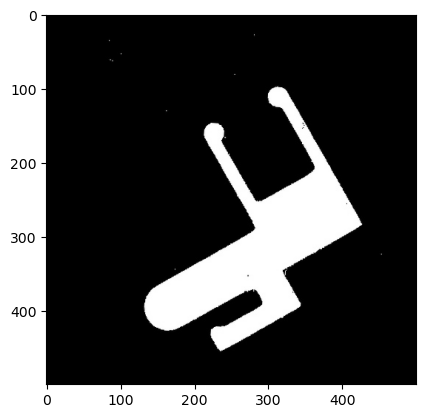

In [11]:
import matplotlib.pyplot as plt
image_np = np.array(image)
if len(image_np.shape) == 2:  # Check if the image is grayscale
    image_np = np.stack([image_np] * 3, axis=-1)  # Repeat the grayscale channel three times
plt.imshow(image_np)
image =  Image.fromarray(image_np)


In [12]:
import matplotlib.pyplot as plt
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

In [13]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

model_name = r"C:\Part_dimensions_project\seg_former_model_weights\best_weights"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [14]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits



In [15]:

upsampled_logits = torch.nn.functional.interpolate(logits, size=(512 , 512), mode="bilinear", align_corners=False)
probabilities = torch.sigmoid(upsampled_logits)
    
# Threshold to get binary predictions
predicted = (probabilities > 0.5).int()
predicted = predicted.squeeze(1)
predicted = predicted.cpu().squeeze().numpy()


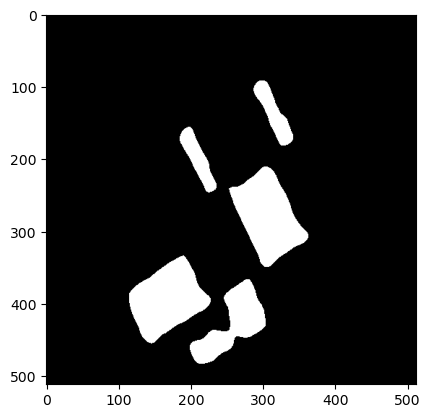

In [16]:
plt.imshow(predicted , cmap = 'gray')

In [6]:
import os
import random
import shutil

def shuffle_and_rename(directory1, directory2):
    # Get lists of files in both directories
    files1 = os.listdir(directory1)
    files2 = os.listdir(directory2)

    # Ensure both directories have the same number of files
    assert len(files1) == len(files2), "Directories must contain the same number of files."
    
    
    def extract_number(filename):
        match = re.search(r'(\d+)', filename)
        return int(match.group(1)) if match else -1

    # Sort the files based on the extracted integer values
    files1.sort(key=extract_number)

    files2.sort(key=extract_number)
    
    
    # Zip the lists together to maintain correspondence
    combined = list(zip(files1, files2))

    # Shuffle the combined list
    random.shuffle(combined)

    # Unzip the shuffled list
    shuffled_files1, shuffled_files2 = zip(*combined)

    # Rename files in directory1
    for idx, file in enumerate(shuffled_files1):
        old_path = os.path.join(directory1, file)
        new_name = f"shuffled_image_{idx + 1}{os.path.splitext(file)[1]}"
        new_path = os.path.join(directory1, new_name)
        os.rename(old_path, new_path)

    # Rename files in directory2
    for idx, file in enumerate(shuffled_files2):
        old_path = os.path.join(directory2, file)
        new_name = f"shuffled_label_{idx + 1}{os.path.splitext(file)[1]}"
        new_path = os.path.join(directory2, new_name)
        os.rename(old_path, new_path)

# Specify the directories
directory1 = r"C:\Part_dimensions_project\dataset\training\images"
directory2 = r"C:\Part_dimensions_project\dataset\training\annotations"

# Call the function to shuffle and rename files
shuffle_and_rename(directory1, directory2)
